In [1]:
!pip install fastai

    100% |################################| 122kB 2.5MB/s 
    100% |################################| 112kB 28.2MB/s 
    100% |################################| 1.9MB 17.5MB/s 
    100% |################################| 23.3MB 3.4MB/s 
    100% |################################| 61kB 21.9MB/s 
    100% |################################| 163kB 30.8MB/s 
    100% |################################| 655kB 30.5MB/s 
    100% |################################| 317kB 27.7MB/s 
    100% |################################| 153kB 29.1MB/s 
    100% |################################| 450kB 30.8MB/s 
    100% |################################| 92kB 26.3MB/s 
    100% |################################| 194kB 38.8MB/s 
    100% |################################| 51kB 18.3MB/s 
  Running setup.py bdist_wheel for bottleneck ... done
  Stored in directory: /root/.cache/pip/wheels/f2/bf/ec/e0f39aa27001525ad455139ee57ec7d0776fe074dfd78c97e4
  Running setup.py bdist_wheel for regex ... done
  Stored in 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from fastai import *
from fastai.tabular import *

In [3]:
train_set = pd.read_csv("train.csv")
test_set = pd.read_csv("test.csv")

In [4]:
train_set = train_set.loc[:,'user_id':'is_click']
train_set.head()

,user_id,product,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,age_level,user_depth,city_development_index,var_1,is_click
0,858557,C,359520,13787,4,NaN,10.0,Female,4.0,3.0,3.0,0,0
1,243253,C,105960,11085,5,NaN,8.0,Female,2.0,2.0,NaN,0,0
2,243253,C,359520,13787,4,NaN,8.0,Female,2.0,2.0,NaN,0,0
3,1097446,I,359520,13787,3,NaN,3.0,Male,3.0,3.0,2.0,1,0
4,663656,C,405490,60305,3,NaN,2.0,Male,2.0,3.0,2.0,1,0


In [5]:
test_set = test_set.loc[:,'user_id':'var_1']
test_set.head()

,user_id,product,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,age_level,user_depth,city_development_index,var_1
0,732573,J,404347,53587,1,NaN,5.0,Male,5.0,3.0,NaN,0
1,172910,I,118601,28529,3,82527.0,NaN,NaN,NaN,NaN,NaN,1
2,172910,I,118601,28529,4,82527.0,NaN,NaN,NaN,NaN,NaN,1
3,557318,G,118601,28529,5,82527.0,1.0,Male,1.0,3.0,1.0,0
4,923896,H,118601,28529,5,82527.0,9.0,Female,3.0,1.0,NaN,1


In [26]:
dep_var = "is_click"
cat_names = ['product', 'product_category_1', 'product_category_2', 'user_group_id', 'gender', 'age_level', 'user_depth', 'city_development_index', 'var_1']
cont_names = ['user_id', 'campaign_id', 'webpage_id']

In [113]:
procs = [FillMissing, Categorify, Normalize]
test = TabularList.from_df(test_set.copy(), cat_names=cat_names, cont_names=cont_names, procs=procs)

In [114]:
data = (TabularList.from_df(train_set, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(list(range(int(.2*len(train_set)))))
                           .label_from_df(cols=dep_var)
                           .add_test(test, label=0)
                           .databunch())

In [115]:
data.show_batch(rows=10)

product,product_category_1,product_category_2,user_group_id,gender,age_level,user_depth,city_development_index,var_1,user_id,campaign_id,webpage_id,target
E,1,146115.0,11.0,Female,5.0,3.0,2.0,0,-1.3754,-1.7345,-1.3194,0
H,3,nan,5.0,Male,5.0,3.0,2.0,0,0.2960,0.7841,1.4211,0
C,3,nan,3.0,Male,3.0,3.0,2.0,0,-0.0101,0.7841,1.4211,0
D,4,nan,3.0,Male,3.0,3.0,2.0,1,0.4042,0.4259,-0.7555,1
I,4,82527.0,4.0,Male,4.0,3.0,4.0,1,0.5354,-1.4518,-0.0657,0
C,5,nan,2.0,Male,2.0,2.0,1.0,0,-0.0488,0.4369,-0.7555,0
C,3,nan,2.0,Male,2.0,3.0,3.0,0,0.7757,0.7841,1.4211,0
I,4,82527.0,4.0,Male,4.0,3.0,4.0,1,1.7603,-1.4518,-0.0657,0
H,1,146115.0,1.0,Male,1.0,3.0,3.0,0,1.7800,0.7752,1.1068,0
B,2,nan,2.0,Male,2.0,3.0,3.0,1,-1.1441,-1.6048,-1.0744,0


In [118]:
learn = tabular_learner(data, layers=[250,1000,250], metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


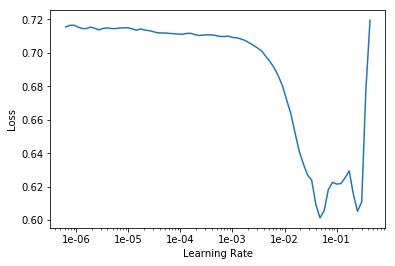

In [119]:
learn.lr_find()
learn.recorder.plot()

In [120]:
learn.fit(2, 1e-2, wd=1e-4)

Total time: 01:50
epoch  train_loss  valid_loss  accuracy
1      0.241954    0.260434    0.926903  (00:55)
2      0.237739    0.260896    0.926860  (00:54)



In [121]:
learn.fit(1, 1e-3)

Total time: 00:55
epoch  train_loss  valid_loss  accuracy
1      0.244983    0.258435    0.927022  (00:55)



In [122]:
df = pd.DataFrame()

In [123]:
x, y, z = learn.predict(test_set.loc[0])
z

tensor([0.9121, 0.0879])

In [124]:
for i in range(len(test_set)):
    x, y, z = learn.predict(test_set.loc[i])
    a, b = z.split(split_size=1)
    df.loc[i,'is_click']= np.array(b)

In [125]:
test_set = pd.read_csv("test.csv")
result = pd.concat([test_set['session_id'], df['is_click']], axis=1)

In [128]:
result.to_csv("result1.csv", index=False)